In [1]:
# calling all the required library for some basic EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats.distributions import chi2
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt

sns.set()

In [2]:
raw_data = pd.read_csv('data/Gold_data.csv')
df_working = raw_data.copy()
df_working = df_working[::-1]
df_working.Date = pd.to_datetime(df_working.Date, dayfirst= True)
df_working.set_index('Date', inplace = True)
#df_working = df_working.asfreq('b')
#df_working = df_working.fillna(method = 'ffill')
df_working.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2003-01-31,368.3,368.8,371.5,367.0,6.54K,-0.08%
2003-02-03,370.8,368.0,372.0,368.0,0.82K,0.68%
2003-02-04,379.0,371.4,379.5,371.2,1.36K,2.21%
2003-02-05,376.4,379.0,388.9,374.0,0.83K,-0.69%
2003-02-06,370.1,370.0,377.0,368.4,0.73K,-1.67%


In [3]:
# reversing the dataframe
# df_working = df_working[::-1]
# df_working.head()

#### Splitting the data!

In [4]:
size = int(len(df_working)*0.8)

In [5]:
df_train = df_working.iloc[:size]
df_train.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-07-04,1258.1,1256.2,1262.4,1255.3,-,-6.27%
2018-07-05,1347.4,1347.4,1347.4,1347.4,0.01K,7.10%
2018-07-06,1344.6,1344.6,1344.6,1344.6,0.01K,-0.21%
2018-07-09,1348.8,1348.8,1348.8,1348.8,0.04K,0.31%
2018-07-10,1344.9,1344.9,1344.9,1344.9,0.07K,-0.29%


In [6]:
df_test = df_working.iloc[size:]
df_test.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-07-11,1333.1,1333.1,1333.1,1333.1,0.03K,-0.88%
2018-07-12,1335.2,1335.2,1335.2,1335.2,0.01K,0.16%
2018-07-13,1329.0,1327.0,1327.0,1327.0,0.00K,-0.46%
2018-07-16,1327.5,1327.5,1327.5,1327.5,0.00K,-0.11%
2018-07-17,1314.6,1320.0,1320.0,1320.0,0.03K,-0.97%


#### Checking if the dataset comes from a stationary process!

In [7]:
# AD Fuller test
sts.adfuller(df_working.Price)

(-1.049540448968919,
 0.7347697335392592,
 9,
 4919,
 {'1%': -3.431680090621068,
  '5%': -2.8621277540961243,
  '10%': -2.5670828625840674},
 42003.429472152646)

##### from the above AD Fuller test, we see that the t-statistic value : -0.804 is significantly greater than the all the threshold given below i.e. 1%,5% and 10%, therefore we dont find sufficient evidence of stationary in the dataset. Also, from the p-value which is associated with t-statistics is 0.81 in our case, suggests that there is 81% chance of not rejecting the null hypothesis, so we can confirm if the data is stationary or not! and the next number which is lag: 26,it represents that it used 26 lags in regression when determining the t-statistics and it suggests us that there is some autocorrelation going on back 9 periods.In the next line the number 4973 is the number of observations used in the analysis and both number of lags and number of observations should add up to the total number of datapoints in the dataset. The last number estimates the maximized information criteria provided there is some apparent autocorrelation. The lower the value, the easier it is to make prediction for the future.

### Seasonal Decomposition

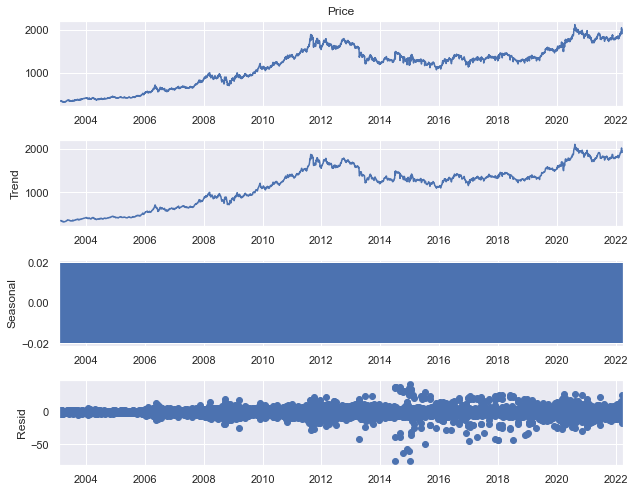

In [8]:
plt.rcParams['figure.figsize'] = [9.0,7.0]
additive_s_decomp = seasonal_decompose(df_working.Price, model="additive", period = 2)
additive_s_decomp.plot()
plt.show()

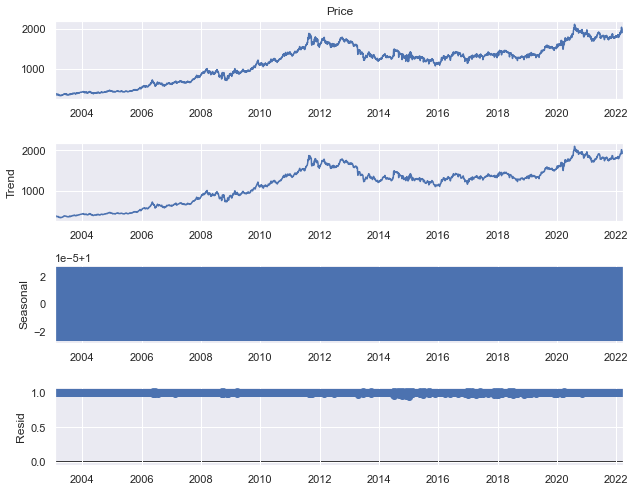

In [9]:
additive_s_decomp = seasonal_decompose(df_working.Price, model="multiplicative", period = 2)
additive_s_decomp.plot()
plt.show()

#### checking the autocorrelation in the dataset

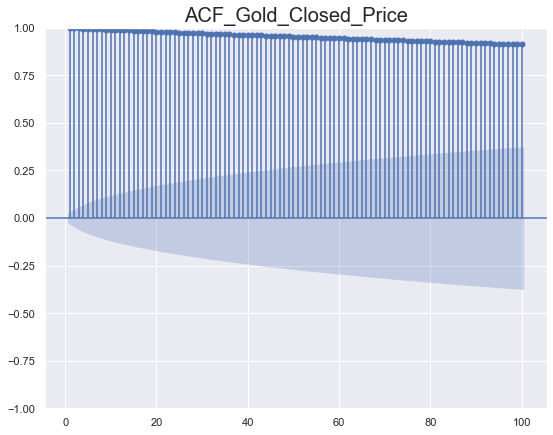

In [10]:
sgt.plot_acf(df_working.Price, lags = 100, zero = False)
plt.title('ACF_Gold_Closed_Price',size = 20)
plt.show()

#### the the above plot we can conclude that the autocorrelation barely diminishes as the lag increases. This, in turn, suggests that prices even a month back can still serve as a decent estimate!

### Partial AutoCorrelation Plot

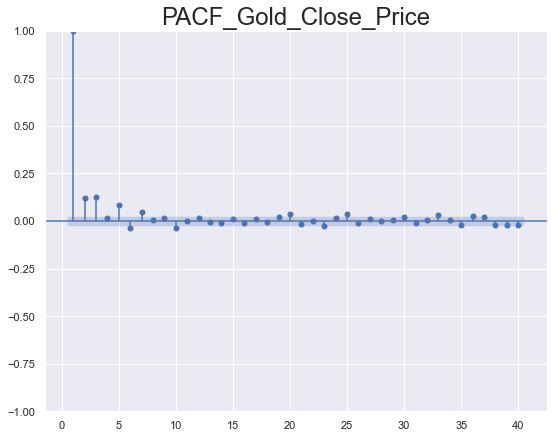

In [11]:
sgt.plot_pacf(df_working.Price, lags = 40, zero = False, method = ('ols'))
plt.title('PACF_Gold_Close_Price', size = 24)
plt.show()

### Models:

#### AR Model

In [12]:
model_AR = AutoReg(df_train.Price, 1)
results_AR = model_AR.fit()
print(results_AR.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Price   No. Observations:                 3943
Model:                     AutoReg(1)   Log Likelihood              -16881.402
Method:               Conditional MLE   S.D. of innovations             17.523
Date:                Thu, 21 Jul 2022   AIC                          33768.804
Time:                        17:50:58   BIC                          33787.642
Sample:                             1   HQIC                         33775.487
                                 3943                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4293      0.746      1.915      0.055      -0.034       2.892
Price.L1       0.9989      0.001   1517.630      0.000       0.998       1.000
                                    Roots           

c:\Users\Asus\anaconda3\envs\deepL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [13]:
model_AR_5 = AutoReg(df_train.Price, 6)
results_AR_5 = model_AR_5.fit()
print(results_AR_5.summary())

                            AutoReg Model Results                             
Dep. Variable:                  Price   No. Observations:                 3943
Model:                     AutoReg(6)   Log Likelihood              -16766.398
Method:               Conditional MLE   S.D. of innovations             17.111
Date:                Thu, 21 Jul 2022   AIC                          33548.796
Time:                        17:50:58   BIC                          33599.022
Sample:                             6   HQIC                         33566.614
                                 3943                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3539      0.730      1.853      0.064      -0.078       2.786
Price.L1       0.8442      0.016     53.032      0.000       0.813       0.875
Price.L2      -0.0029      0.021     -0.138      0.8

c:\Users\Asus\anaconda3\envs\deepL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Loglikely ratio test

In [14]:
def LLR(mod1, mod2,DF):
    L1 = mod1.fit().llf
    L2 = mod2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [15]:
LLR(model_AR, model_AR_5, DF = 1)

0.0

### Lets create percentage change in the closing price out of Price col (if the price has increased from the previous day, then the return will be positive else its negative), we do this to convert the timeseries from non-stationary to stationary process.

In [16]:
df_train['Percentage_Change_Close_Price'] = df_train.Price.pct_change(1).mul(100)
df_train = df_train.iloc[1:] # removing the first row of the df_train dataframe as when we calculate Close_Price_% , we will get null values in the first row.

C:\Users\Asus\AppData\Local\Temp\ipykernel_8780\3036573149.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Percentage_Change_Close_Price'] = df_train.Price.pct_change(1).mul(100)


In [17]:
df_train.head()

,Price,Open,High,Low,Vol.,Change %,Percentage_Change_Close_Price
Date,,,,,,,
2003-02-03,370.8,368.0,372.0,368.0,0.82K,0.68%,0.678794
2003-02-04,379.0,371.4,379.5,371.2,1.36K,2.21%,2.211435
2003-02-05,376.4,379.0,388.9,374.0,0.83K,-0.69%,-0.686016
2003-02-06,370.1,370.0,377.0,368.4,0.73K,-1.67%,-1.673751
2003-02-07,369.9,370.5,374.5,367.5,0.18K,-0.05%,-0.054039


In [18]:
sts.adfuller(df_train.Percentage_Change_Close_Price)

(-27.37575403716489,
 0.0,
 5,
 3936,
 {'1%': -3.432012492343266,
  '5%': -2.8622745981442903,
  '10%': -2.5671610349768037},
 14089.985770509333)

#### from the above df test we can state that the time series comes from stationary process (t-stat : -27.37 falls really far from the 1% significance value) 

# ___
#### lets computer aut-correlation and partial auto-correlation of the newly generated stationary time series dataset 

#### ACF and PACF of Percentage_Change_Close_Price

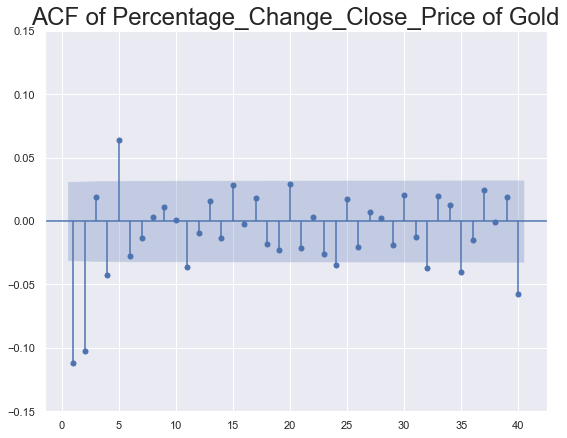

In [19]:
sgt.plot_acf(df_train.Percentage_Change_Close_Price, lags = 40, zero = False)
plt.ylim(-0.15,0.15)
plt.title('ACF of Percentage_Change_Close_Price of Gold', size = 24)
plt.show()

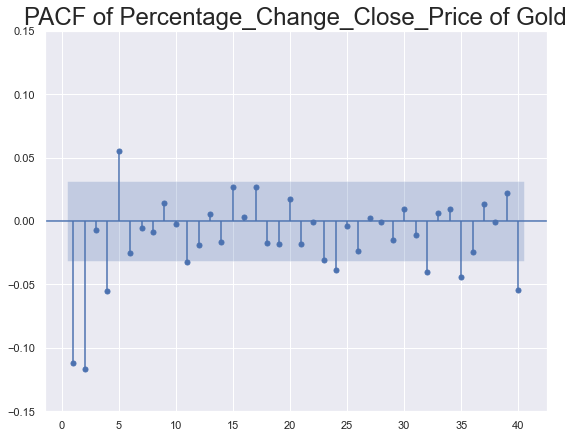

In [20]:
sgt.plot_pacf(df_train.Percentage_Change_Close_Price, lags = 40, zero = False, method = ('ols'))
plt.ylim(-0.15,0.15)
plt.title('PACF of Percentage_Change_Close_Price of Gold', size = 24)
plt.show()

#### from the PACF plot we see that higher lags has very less significance on the new price formed in the marker and its clearly seen that first few lags (upto 5) have more significance than the higher ones shaded in the blue region.

# _____
### Building AR model with the new stationary data

In [21]:
model_AR_ch = AutoReg(df_train.Percentage_Change_Close_Price, lags = 5)
result_model_AR_ch = model_AR_ch.fit()
print(result_model_AR_ch.summary())

                                  AutoReg Model Results                                  
Dep. Variable:     Percentage_Change_Close_Price   No. Observations:                 3942
Model:                                AutoReg(5)   Log Likelihood               -7087.972
Method:                          Conditional MLE   S.D. of innovations              1.464
Date:                           Thu, 21 Jul 2022   AIC                          14189.944
Time:                                   17:50:59   BIC                          14233.892
Sample:                                        5   HQIC                         14205.535
                                            3942                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                                0.0545      0.023      2.330      0.020  

c:\Users\Asus\anaconda3\envs\deepL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Normalizing 'Close' price values

In [22]:
df_train['Normalize_Close'] = df_train.Price.div(df_train.Price.iloc[0]).mul(100)

In [23]:
df_train.head()

,Price,Open,High,Low,Vol.,Change %,Percentage_Change_Close_Price,Normalize_Close
Date,,,,,,,,
2003-02-03,370.8,368.0,372.0,368.0,0.82K,0.68%,0.678794,100.000000
2003-02-04,379.0,371.4,379.5,371.2,1.36K,2.21%,2.211435,102.211435
2003-02-05,376.4,379.0,388.9,374.0,0.83K,-0.69%,-0.686016,101.510248
2003-02-06,370.1,370.0,377.0,368.4,0.73K,-1.67%,-1.673751,99.811219
2003-02-07,369.9,370.5,374.5,367.5,0.18K,-0.05%,-0.054039,99.757282


In [24]:
sts.adfuller(df_train.Normalize_Close)

(-1.5481609603105744,
 0.5095666896514159,
 9,
 3932,
 {'1%': -3.432014184692783,
  '5%': -2.8622753457262213,
  '10%': -2.5671614329589802},
 23090.976207245898)

#### from the above adfuller test on Normalized dataset of closed porces dint not yield a stationary data. Therefore we cannot use AR model with normalized prices.

#### Normalizing 'Percentage_Change_Close_Price	'  values

In [25]:
df_train['Normalize_Close_Percentage_Change'] = df_train.Percentage_Change_Close_Price.div(df_train.Percentage_Change_Close_Price.iloc[0]).mul(100)

In [26]:
df_train.head()

,Price,Open,High,Low,Vol.,Change %,Percentage_Change_Close_Price,Normalize_Close,Normalize_Close_Percentage_Change
Date,,,,,,,,,
2003-02-03,370.8,368.0,372.0,368.0,0.82K,0.68%,0.678794,100.000000,100.000000
2003-02-04,379.0,371.4,379.5,371.2,1.36K,2.21%,2.211435,102.211435,325.788565
2003-02-05,376.4,379.0,388.9,374.0,0.83K,-0.69%,-0.686016,101.510248,-101.063852
2003-02-06,370.1,370.0,377.0,368.4,0.73K,-1.67%,-1.673751,99.811219,-246.577046
2003-02-07,369.9,370.5,374.5,367.5,0.18K,-0.05%,-0.054039,99.757282,-7.961092


In [27]:
sts.adfuller(df_train.Normalize_Close_Percentage_Change)

(-27.375754037164885,
 0.0,
 5,
 3936,
 {'1%': -3.432012492343266,
  '5%': -2.8622745981442903,
  '10%': -2.5671610349768037},
 53132.17322664036)

From the above stats we can say that this data is stationary even after normalizing the percentage change of close price.

#### AR Model for Normalize Value

In [28]:
model_AR_Norm_ch = AutoReg(df_train.Normalize_Close_Percentage_Change, lags = 10)
result_model_AR_Norm_ch = model_AR_Norm_ch.fit()
print(result_model_AR_Norm_ch.summary())

                                    AutoReg Model Results                                    
Dep. Variable:     Normalize_Close_Percentage_Change   No. Observations:                 3942
Model:                                   AutoReg(10)   Log Likelihood              -26706.404
Method:                              Conditional MLE   S.D. of innovations            215.536
Date:                               Thu, 21 Jul 2022   AIC                          53436.808
Time:                                       17:51:00   BIC                          53512.131
Sample:                                           10   HQIC                         53463.531
                                                3942                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                               

c:\Users\Asus\anaconda3\envs\deepL\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Residual Analysis

In [29]:
#df_train['residual_price'] = model_AR_Norm_ch.fit().resid

In [30]:
#df_train.residual_price.mean()

In [31]:
#df_train.residual_price.var()

In [32]:
#df_train.head()